<a href="https://colab.research.google.com/github/Saarle/Regression-Project/blob/main/Regression_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regression Project





In [11]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

In [3]:
path = csv_drive_path_generatoer('https://drive.google.com/file/d/1R3vBFIn6YPrgpvyAADCY0yAYthaGy9NF/view?usp=sharing')
path_y = csv_drive_path_generatoer('https://drive.google.com/file/d/10wLZgOF00TY5Kmg0d_rn_agoEAFMVbwB/view?usp=sharing')
X = pd.read_csv(path)
y=  pd.read_csv(path_y)
print(X.sample(5))
print(y.sample(5))

      Unnamed: 0.1  Unnamed: 0   Age Gender  Education Level  \
178           2755        2755  31.0      F  bachelor's|degr   
4871          2097        2097  30.0      F  bachelor's|degr   
586            174         174  28.0      F           master   
2055           178         178  39.0      F         bachelor   
4622          3691        3691  29.0      F    master's|degr   

                              Job Title  Years of Experience Country  \
178                    software|enginee                  6.0      us   
4871                 front|end|develope                  6.0       u   
586                junior|data|scientis                  3.5   canad   
2055  senior|human|resources|coordinato                 11.0       u   
4622         human|resources|coordinato                  5.0    chin   

                  Race    height     weight    id  professionalism  
178   African American  2.302699  62.514257  2755            150.0  
4871             White  1.664362  57.722055 

In [7]:
X.rename(columns = {"Unnamed: 0.1": "Id1",
                    "Unnamed: 0": "Id2",
                    "Education Level":"Education_Level",
                    "Job Title": "Job_Title",
                   "Years of Experience": "Years_of_Experience"},
                    inplace=True)

column_order =['id','Id1','Id2','Gender','Education_Level','Job_Title','Years_of_Experience','Country','Race','height','weight','professionalism']
X = X[column_order]

In [13]:
data = X.join(y)
data.set_index('id' , inplace= True)
data.sort_values(by='id')

,Id1,Id2,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Unnamed: 0,Salary
id,,,,,,,,,,,,,
0,0,0,NaN,bachelor,software|enginee,120.0,RazShmuelykingdom,NayaCollegegeek,2.492683,200.000000,160.0,0,90000.0
1,1,1,NaN,master,data|analys,120.0,RazShmuelykingdom,NayaCollegegeek,2.480525,200.000000,84.0,1,65000.0
4,4,4,M,master,directo,22.0,us,Asian,1.522019,105.799514,1040.0,4,200000.0
5,5,5,M,bachelor,marketing|analys,4.0,us,Hispanic,1.949831,49.868702,58.0,5,55000.0
6,6,6,F,master,product|manage,13.0,us,Asian,1.537399,87.847470,504.0,6,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697,6697,6697,F,master's|degr,senior|product|marketing|manage,20.0,u,White,2.271163,106.654680,969.0,6697,190000.0
6698,6698,6698,M,bachelor's|degr,junior|sales|representativ,7.0,canad,Asian,2.394349,73.157479,222.0,6698,75000.0
6699,6699,6699,F,p,director|of|marketin,22.0,u,Mixed,1.642822,96.333417,980.0,6699,200000.0


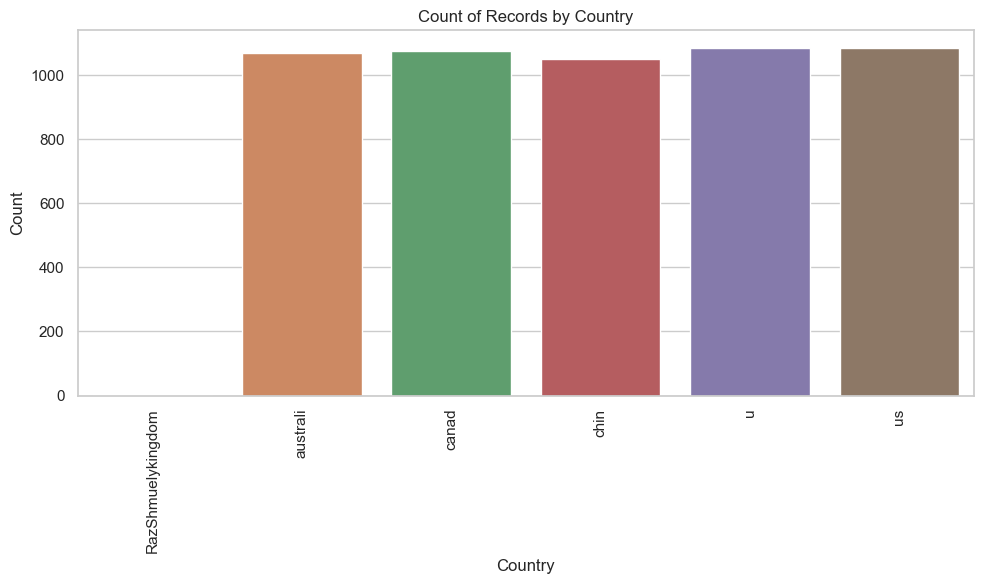

In [35]:
country = data.groupby('Country').size().reset_index(name='Count')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=country, x='Country', y='Count')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Records by Country')
plt.tight_layout()

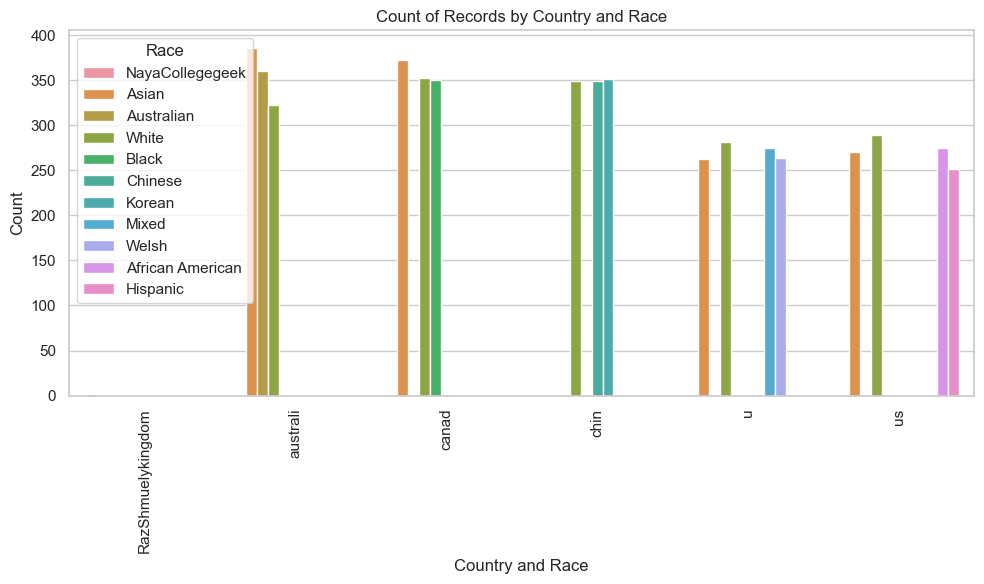

In [38]:
country_race = data.groupby(['Country','Race']).size().reset_index(name='Count')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=country_race, x='Country', y='Count',hue= 'Race')
plt.xticks(rotation=90)
plt.xlabel('Country and Race')
plt.ylabel('Count')
plt.title('Count of Records by Country and Race')
plt.tight_layout()

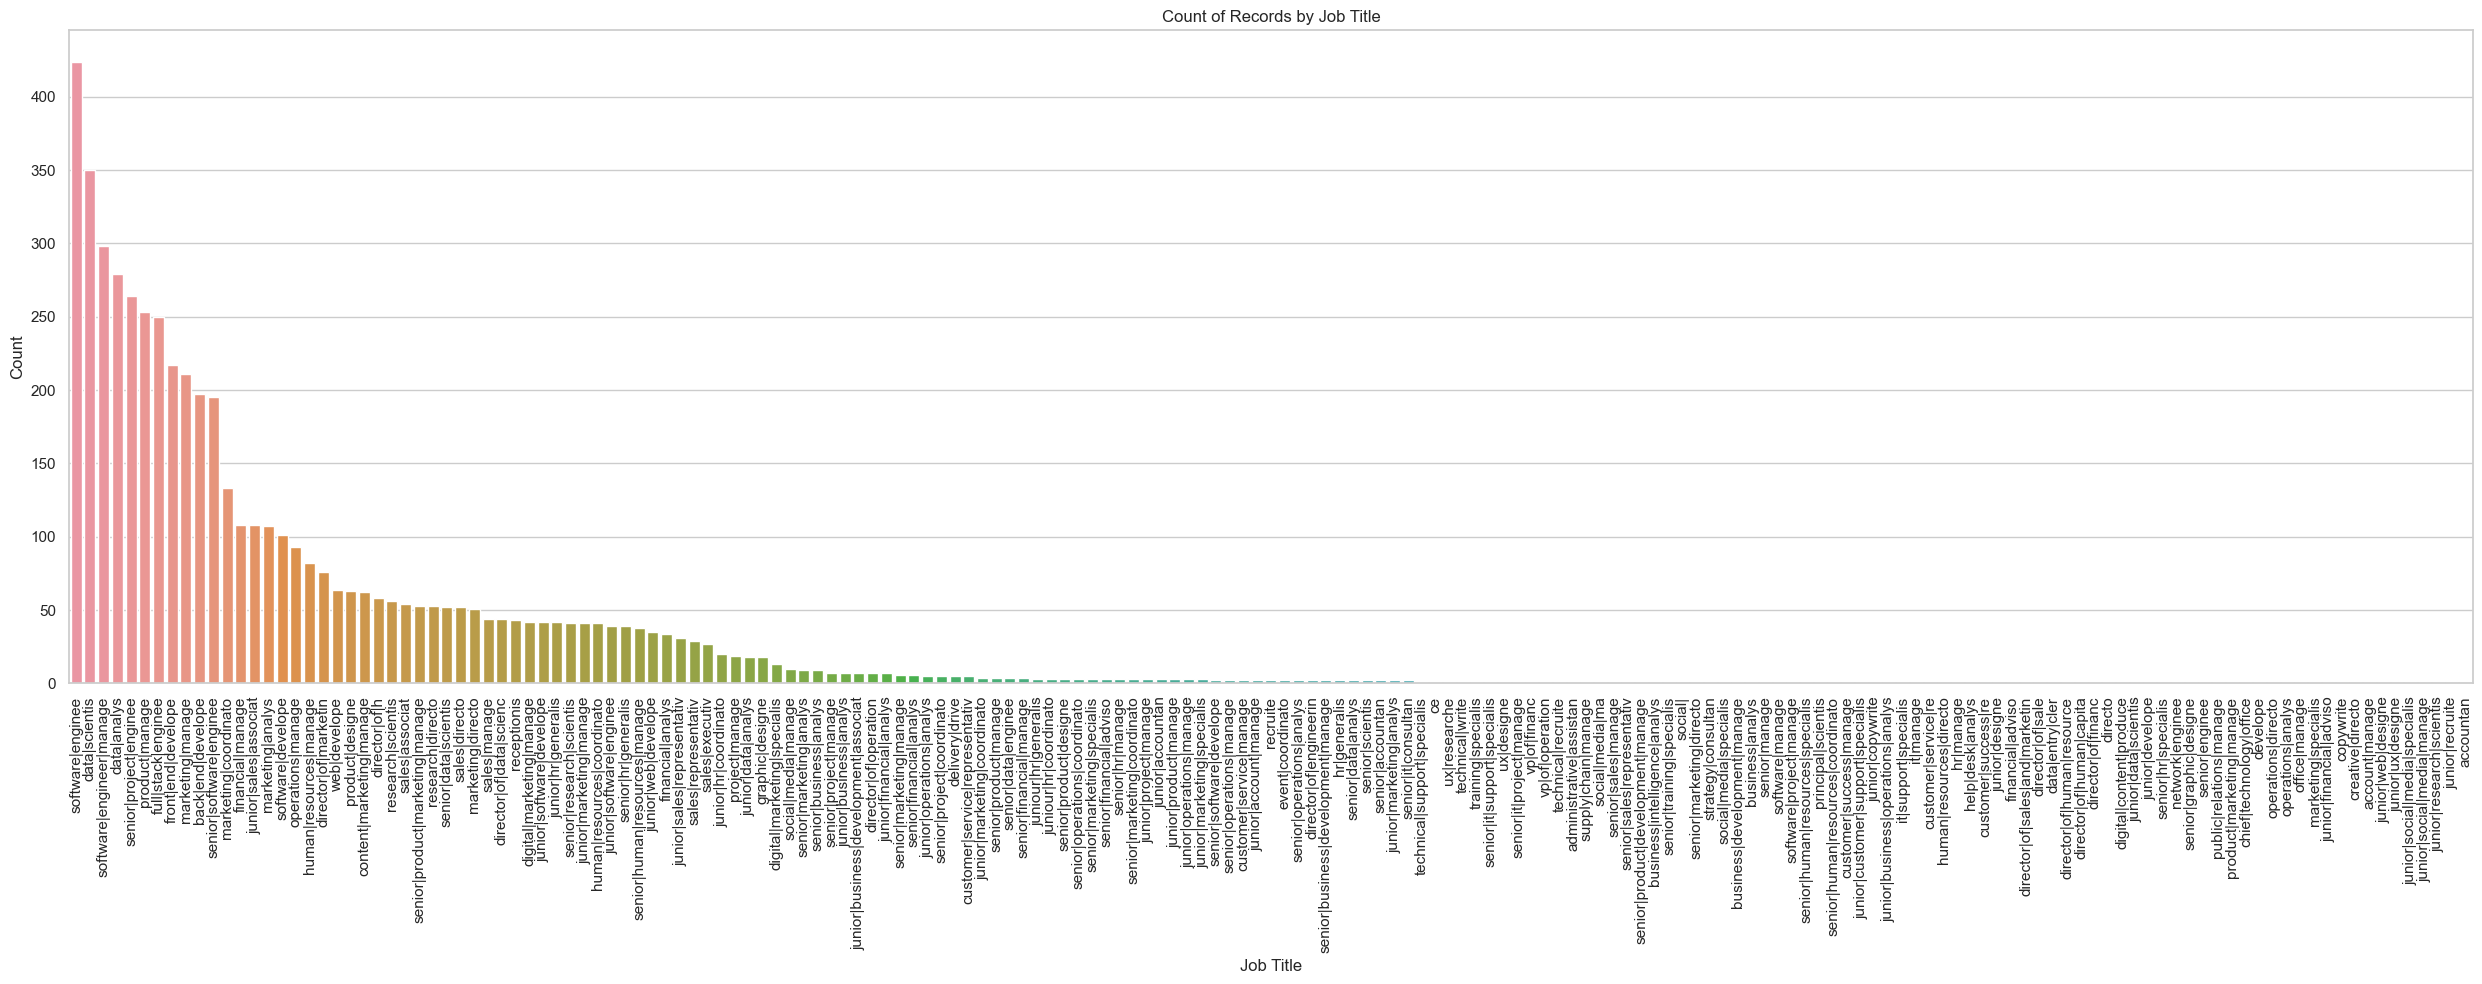

In [52]:
job = data.groupby('Job_Title').size().reset_index(name='count').sort_values(by='count' ,ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data=job, x='Job_Title', y='count')
plt.xticks(rotation=90)
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.title('Count of Records by Job Title')
plt.tight_layout()

<Axes: >

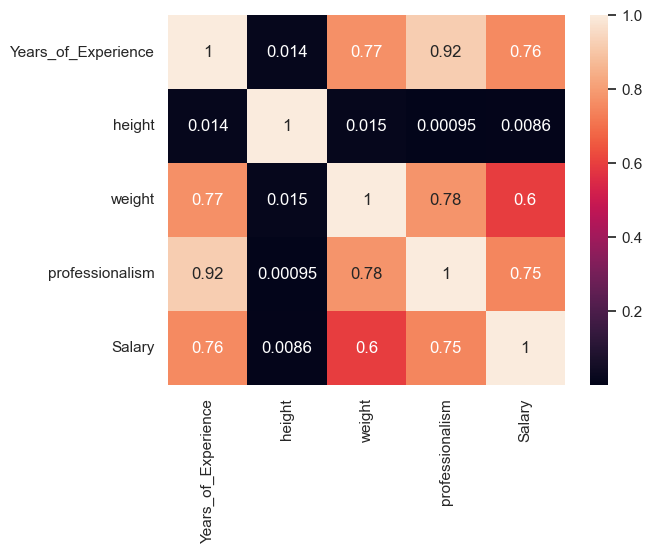

In [53]:
cor = data.corr()

sns.heatmap(cor , annot= True)

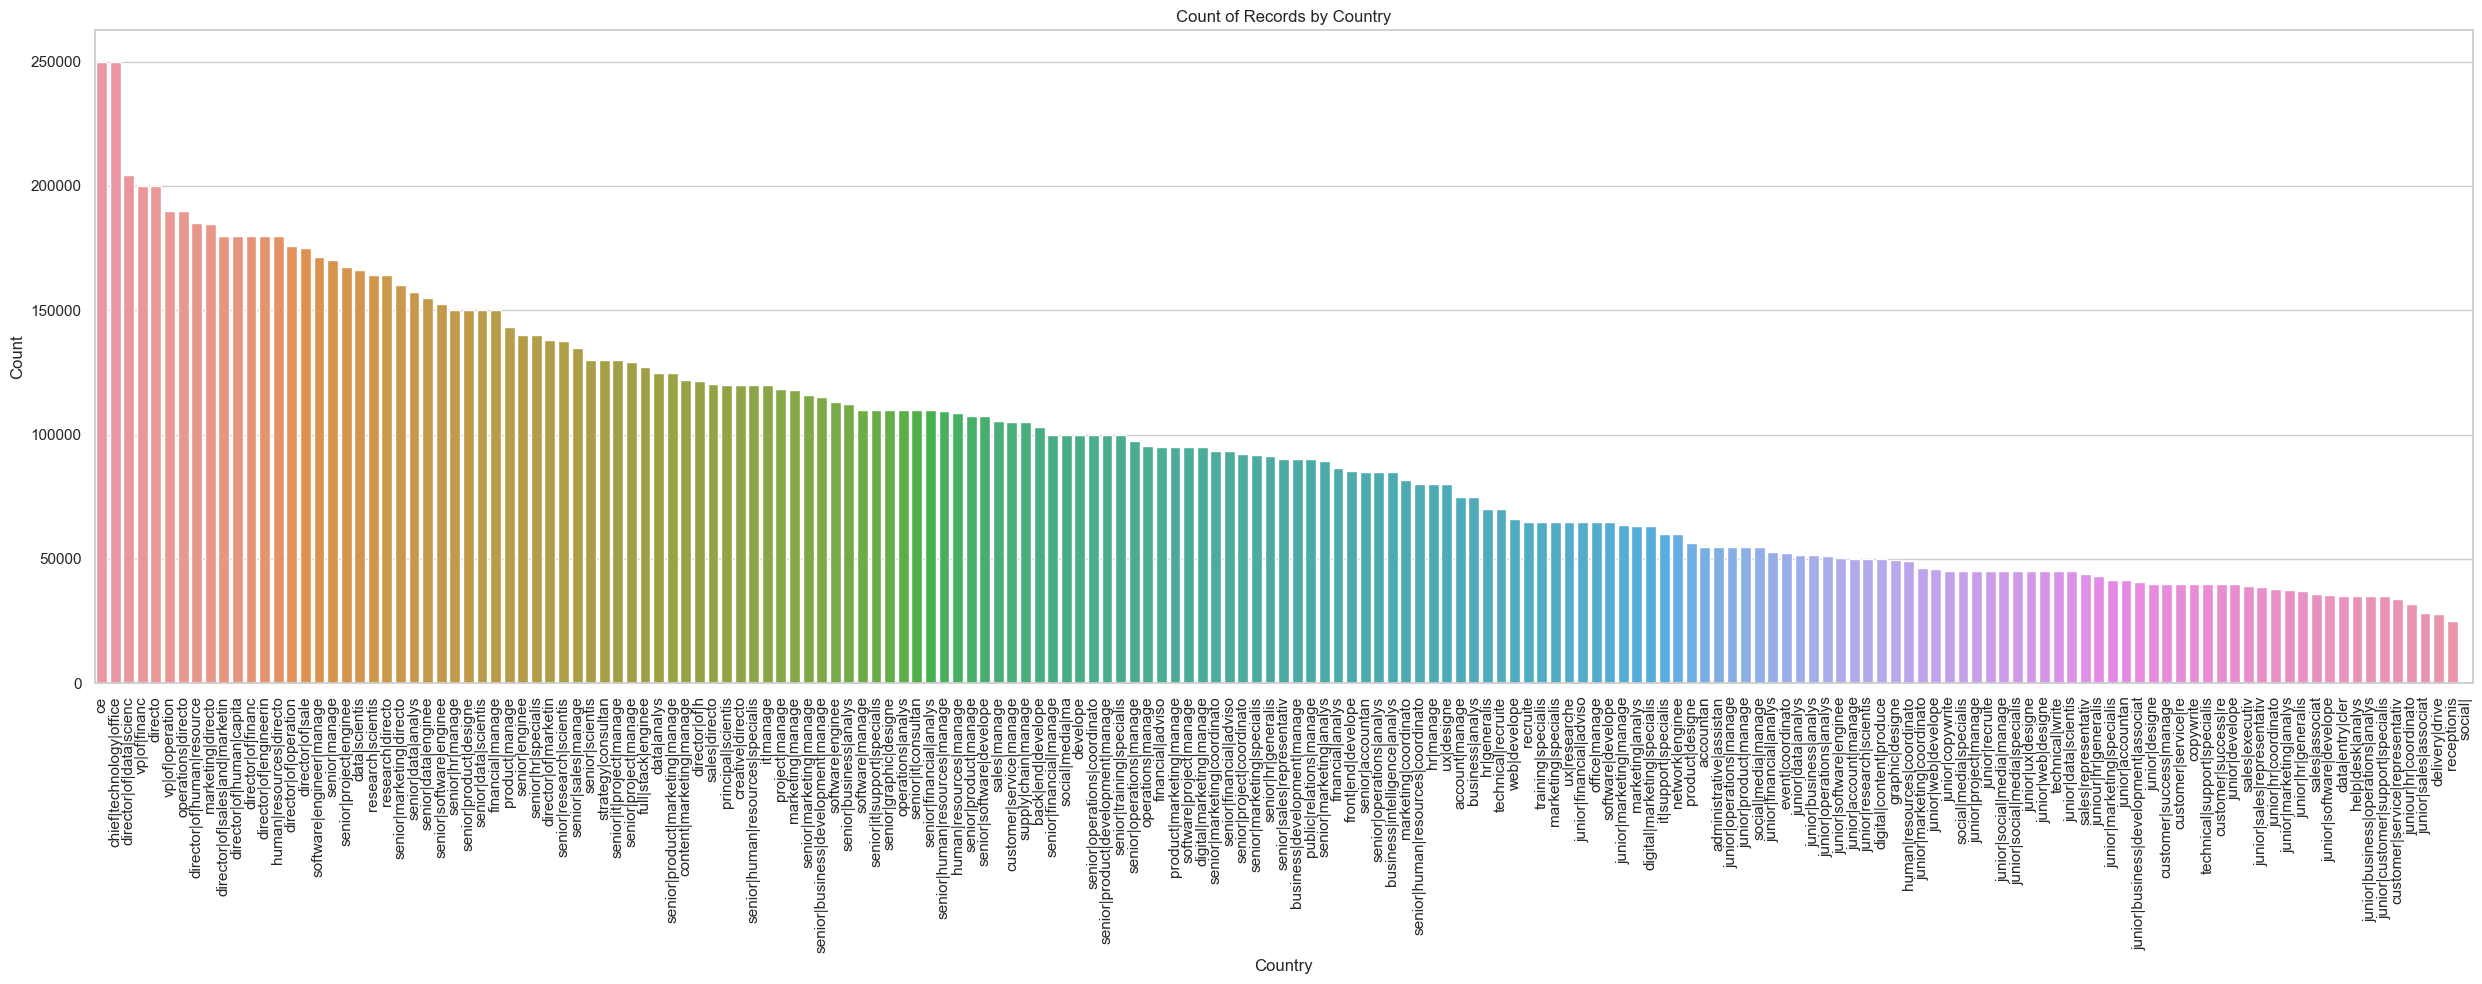

In [49]:
job = data.groupby('Job_Title')['Salary'].mean().reset_index(name='mean').sort_values(by='mean' ,ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data=job, x='Job_Title', y='mean')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Records by Country')
plt.tight_layout()

In [15]:
new_data = data
new_data.drop('Id1' ,axis = 1,inplace = True)
new_data.drop('Id2' ,axis = 1,inplace = True)
new_data.drop('Unnamed: 0' ,axis = 1,inplace = True)

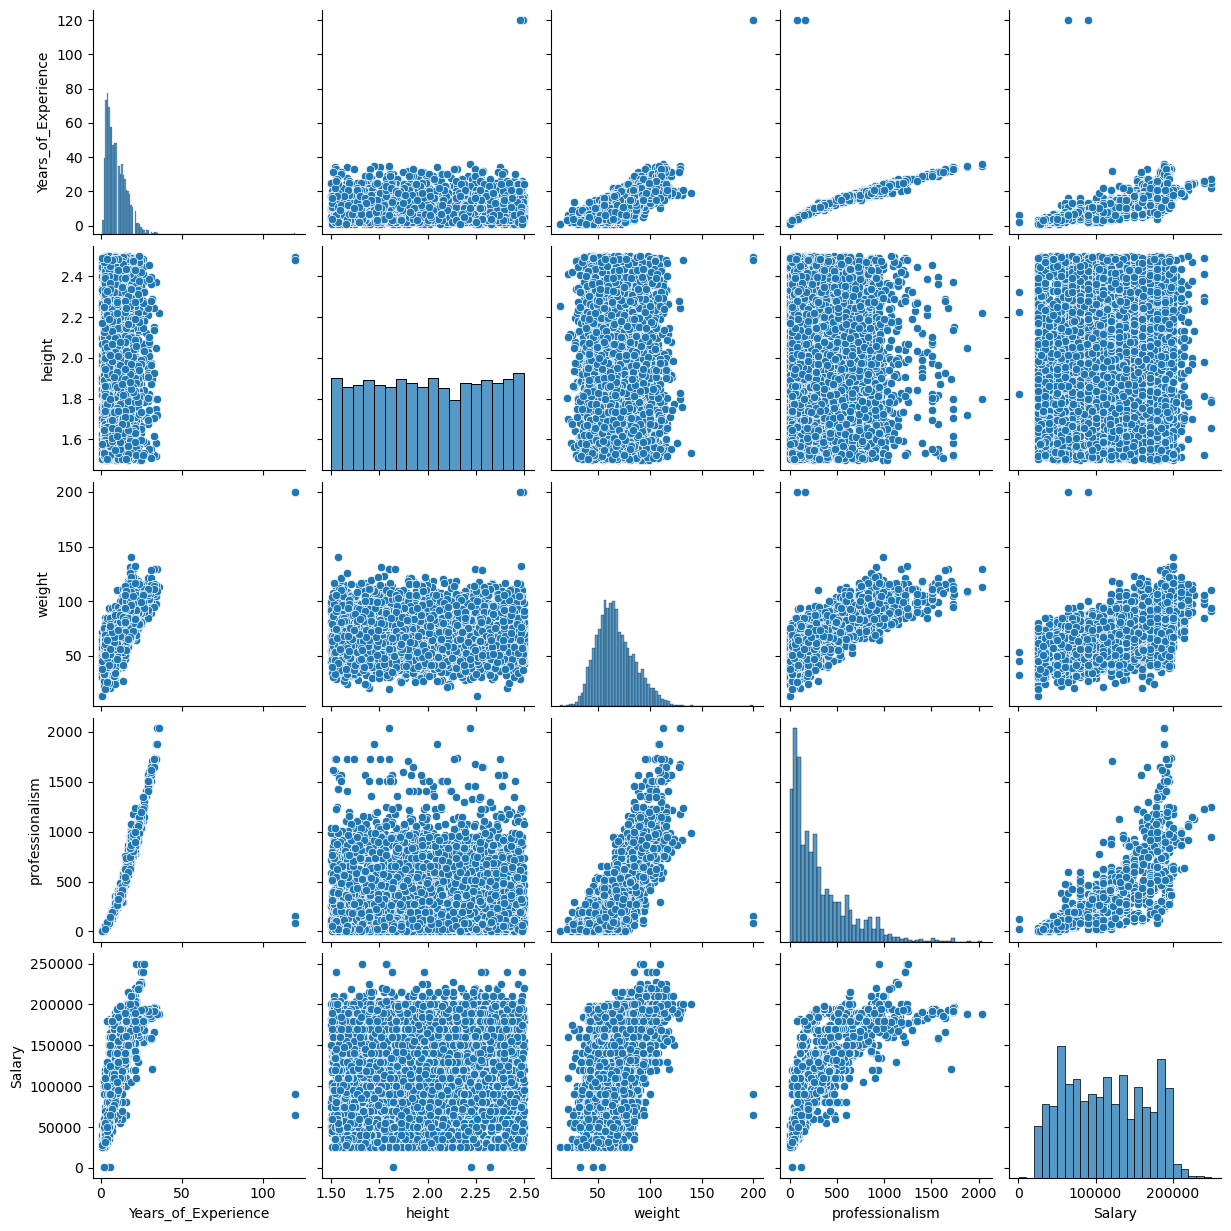

In [16]:
sns.pairplot(new_data)